# Mock analysis H0 prior

This notebook is inspired from [this notebook](https://github.com/TDCOSMO/hierarchy_analysis_2020_public/blob/master/MST_impact/MST_pl_cored.ipynb) of S. Birrer.

Use [this fork](https://github.com/lucateo/lenstronomy/tree/uldm-teodori-inverse-thetac-kappaE) of lenstronomy to make this run, in order not to have problems.

<ipython-input-2-179ea16e6bb6>:139: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad(color='k', alpha=1.)
<ipython-input-2-179ea16e6bb6>:140: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_under('k')
<ipython-input-2-179ea16e6bb6>:147: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


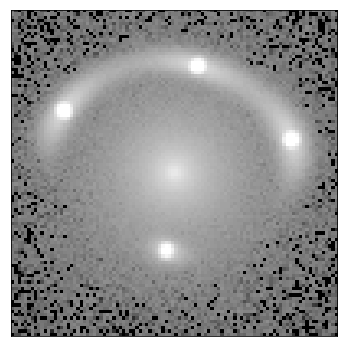

In [2]:
import numpy as np
import os
import time
import copy
import corner
import astropy.io.fits as pyfits
import pickle, h5py
import emcee
import os
from os.path import dirname, abspath

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.constants as const
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from scipy.special import gamma as gamma_func
from lenstronomy.LensModel.Profiles.uldm_pl import Uldm_PL
from scipy.optimize import fsolve

np.random.seed(42)

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.3, Ob0=0.)

# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units # photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'; point spread function
kernel_size = 91

# initial input simulation
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm}
psf_class = PSF(**kwargs_psf)

def find_tilde_theta(x, *arguments):

    tilde_theta = x
    kappa_tilde, inverse_theta_c, theta_E = arguments
    kappa_E = Uldm_PL()._kappa_E(theta_E, tilde_theta, kappa_tilde, inverse_theta_c)
    eq1 = (1 - kappa_E)*theta_E - tilde_theta
    return eq1

def tilde_theta_finder(kappa_tilde, inverse_theta_c, theta_E):

    arguments = (kappa_tilde, inverse_theta_c, theta_E)
    tilde_theta = fsolve(find_tilde_theta, theta_E, args=arguments)
    return tilde_theta[0]

# Lensing Modelling
# lensing quantities
kappa_0 = 0.09
theta_E = 1.66 * (1 - kappa_0)
slope = 3.78
kwargs_pemd = {'theta_E': theta_E, 'gamma': 1.98, 'center_x': 0.0, 'center_y': 0.0, 'e1': -0.2, 'e2': 0.05}  # parameters of the deflector lens model
kwargs_shear = {'gamma1': 0.05, 'gamma2': -0.02}  # shear values to the source plane
kwargs_uldm = {'kappa_0': kappa_0, 'inverse_theta_c': 0.09, 'slope': slope, 'center_x': 0.0, 'center_y': 0.0, }  # parameters of the deflector lens model

# the lens model is a superposition of an elliptical lens model with external shear
lens_model_list = ['PEMD', 'SHEAR', 'ULDM']
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_uldm]
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.
source_y = 0.25*(1 - kappa_0)

# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 2000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)

# lens light model
r_eff = 0.8
lens_light_model_list = ['HERNQUIST']
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
kwargs_hernquist = {'amp': 4000, 'Rs': r_eff*0.551, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_hernquist]

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

# Generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson

data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list,
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

In [3]:
# Time delays
from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
print('Real time delays', dt_days)
dt_sigma = [2, 3, 4]  # Gaussian errors
# Realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

the time delays for the images at position  [-1.690736    1.78597109  0.35554166 -0.11850369] [ 0.94922693  0.50656668  1.62764014 -1.18749349] are:  [-150.55636039 -139.32512683 -123.17099407  -60.85737032]
Real time delays [11.23123356 27.38536632 89.69899007]
the measured relative delays are:  [11.92780606 28.2353371  85.95291069]


In [4]:
# MCMC run
# lens model choicers: initial guess and upper-lower bounds
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

## Power law model
fixed_lens.append({})
kwargs_lens_init.append({'theta_E': 1.64, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0, 'e2': 0., 'kappa_tilde': 0.05, 'sampled_theta_c': 0.1})
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.01, 'center_y': 0.01, 'kappa_tilde': 0.02, 'sampled_theta_c': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10, 'kappa_tilde': 0.001, 'sampled_theta_c': 0.001})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10, 'kappa_tilde': 0.7, 'sampled_theta_c': 1})

## SHEAR model
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.5, 'gamma2': -0.5})
kwargs_upper_lens.append({'gamma1': 0.5, 'gamma2': 0.5})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append(kwargs_hernquist)
kwargs_lens_light_init.append(kwargs_hernquist)
kwargs_lens_light_sigma.append({'Rs': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'Rs': 0, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'Rs': 10, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

# Source choices
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

# Point source model
fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image)), 'dec_image': 0.01 * np.ones(len(x_image))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 4000}
kwargs_cosmo_sigma = {'D_dt': 100}
kwargs_lower_cosmo = {'D_dt': 2000}
kwargs_upper_cosmo = {'D_dt': 6000}

cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

# Use the combined Uldm + PL profile
lens_model_list_uldm = ['ULDM_PL', 'SHEAR']
# Just names of the various models used, like ULDM, SERSIC etc.
kwargs_model_uldm = {'lens_model_list': lens_model_list_uldm,
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }
# Init, upper and lower bound values for all parameters of the model
kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}

# numerical options and fitting sequences
num_source_model = len(source_model_list)
kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
                      }

cosmo_reference = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
lens_cosmo_reference = LensCosmo(z_lens = z_lens, z_source = z_source, cosmo = cosmo_reference)
Ddt_reference = lens_cosmo_reference.ddt

# Defining the prior
class LikelihoodAddition(object):
    import numpy as np

    def __init__(self):
        pass

    def __call__(self, kwargs_lens=None, kwargs_source=None, kwargs_lens_light=None, kwargs_ps=None, kwargs_special=None, kwargs_extinction=None):
        return self.logL_addition(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps, kwargs_special, kwargs_extinction)

    def logL_addition(self, kwargs_lens, kwargs_source=None, kwargs_lens_light=None, kwargs_ps=None, kwargs_special=None, kwargs_extinction=None):
        """
        a definition taking as arguments (kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps, kwargs_special, kwargs_extinction)
                and returns a logL value.
        """
        kappa_tilde = kwargs_lens[0]['kappa_tilde']
        sampled_theta_c = kwargs_lens[0]['sampled_theta_c']
        theta_E = kwargs_lens[0]['theta_E']
        theta_E_MSD = tilde_theta_finder(kappa_tilde, sampled_theta_c, theta_E)
        kappa_E = Uldm_PL()._kappa_E(theta_E, theta_E_MSD, kappa_tilde, sampled_theta_c)

        Ddt_sampled =  kwargs_special['D_dt']
        h0_sampled = 70 * Ddt_reference / Ddt_sampled * (1 - kappa_E)

        h0_mean = 67.4
        h0_sigma = 0.5
        logL = - (h0_sampled - h0_mean)**2 / h0_sigma**2 / 2 + np.log(h0_sampled/Ddt_sampled)

        if 0.001 < kappa_E < 0.5:
            epsilon = 10**(-7)
            deriv = (Uldm_PL()._kappa_E(theta_E, theta_E_MSD, kappa_tilde + epsilon, sampled_theta_c)
                    - Uldm_PL()._kappa_E(theta_E, theta_E_MSD, kappa_tilde - epsilon, sampled_theta_c) )/(2*epsilon)
            deriv = np.abs(deriv)
            return np.log(deriv) + logL
        else:
            return -np.inf
logL_addition = LikelihoodAddition()

# Recall to add here the logL_addition for correct prior
kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': True,
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'time_delay_likelihood': True,
                     'custom_logL_addition': logL_addition
                             }

# kwargs_data contains the image array
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': dt_measured,
                    'time_delays_uncertainties': dt_sigma,}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
mpi = False
from lenstronomy.Workflow.fitting_sequence import FittingSequence

name_flag = 'H0_prior_uldm2uldm'
backup_filename = 'mock_results_'+name_flag+'.h5'
# Set to true if you want to continue a chain
start_from_backup= True

# Set to False if you have already run it
run_sim = True
if run_sim == True:
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model_uldm, kwargs_constraints, kwargs_likelihood, kwargs_params)
    # Do before the PSO to reach a good starting value for MCMC
    if start_from_backup == False:
        fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],
            ['MCMC', {'n_burn': 100, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .2,
                'backup_filename': backup_filename, 'start_from_backup': start_from_backup}]
        ]
    else:
        fitting_kwargs_list = [['MCMC', {'n_burn': 1200, 'n_run': 1500, 'walkerRatio': 10, 'sigma_scale': .2,
                'backup_filename': backup_filename, 'start_from_backup': start_from_backup}]]

    start_time = time.time()
    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    file_name = 'mock_result_store_'+name_flag+'.pkl'
    filedata = open(file_name, 'wb')
    pickle.dump(kwargs_result, filedata)
    filedata.close()

    file_name = 'mock_results_chain_'+name_flag+'.pkl'
    filedata = open(file_name, 'wb')
    pickle.dump(chain_list, filedata)
    filedata.close()
    end_time = time.time()

    print(end_time - start_time, 'total time needed for computation')
else:
    file_name = 'mock_result_store_'+name_flag+'.pkl'
    filedata = open(file_name, 'rb')
    kwargs_result = pickle.load(filedata)
    filedata.close()

    file_name = 'mock_results_chain_'+name_flag+'.pkl'
    filedata = open(file_name, 'rb')
    chain_list = pickle.load(filedata)
    filedata.close()

print('Final parameters given by MCMC: ', kwargs_result)

/home/luca/Weizmann/hierarchy_analysis_2020_public/ULDM/lenstronomy/lenstronomy/Workflow/fitting_sequence.py:229: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sampler_type is 'EMCEE':
/home/luca/Weizmann/hierarchy_analysis_2020_public/ULDM/lenstronomy/lenstronomy/Sampling/Likelihoods/flux_ratio_likelihood.py:43: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self._source_type is 'INF':


  2%|▏         | 30/1500 [08:49<7:16:30, 17.82s/it]/home/luca/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 1500/1500 [7:21:37<00:00, 17.67s/it]  


Computing the MCMC...
Number of walkers =  180
Burn-in iterations:  1200
Sampling iterations (in current run): 1500
26498.359395503998 time taken for MCMC sampling
26499.059796333313 total time needed for computation
Final parameters given by MCMC:  {'kwargs_lens': [{'theta_E': 1.6552790079593314, 'gamma': 1.9895057051769727, 'e1': -0.1971982036598032, 'e2': 0.04913152423364821, 'kappa_tilde': 0.01897994173132879, 'sampled_theta_c': 0.003994118115640627, 'center_x': 0.00033031134758302103, 'center_y': 0.002537789369742625}, {'gamma1': 0.05716815518084376, 'gamma2': -0.02256376048386858, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.10964730585964162, 'n_sersic': 1.0180551029915132, 'e1': 0.05796122357176766, 'e2': 0.09419401085340312, 'center_x': 0.0003948279428810861, 'center_y': 0.25103720535948304}], 'kwargs_lens_light': [{'amp': 4000, 'Rs': 0.4408000000000001, 'center_x': 0, 'center_y': 0}], 'kwargs_ps': [{'ra_image': array([-1.69062024,  1.7858838 ,  0.355408

-0.9990386628963428 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9990386628963425


/home/luca/Weizmann/hierarchy_analysis_2020_public/ULDM/lenstronomy/lenstronomy/Plots/model_band_plot.py:57: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_bad(color='k', alpha=1.)
/home/luca/Weizmann/hierarchy_analysis_2020_public/ULDM/lenstronomy/lenstronomy/Plots/model_band_plot.py:58: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_under('k')
/home/luca/Weizmann/hierarchy_analysis_2020_public/ULDM/lenstronomy/lenstronomy/Plots/model_band_plot.py:88: RuntimeWarning: invalid value encou

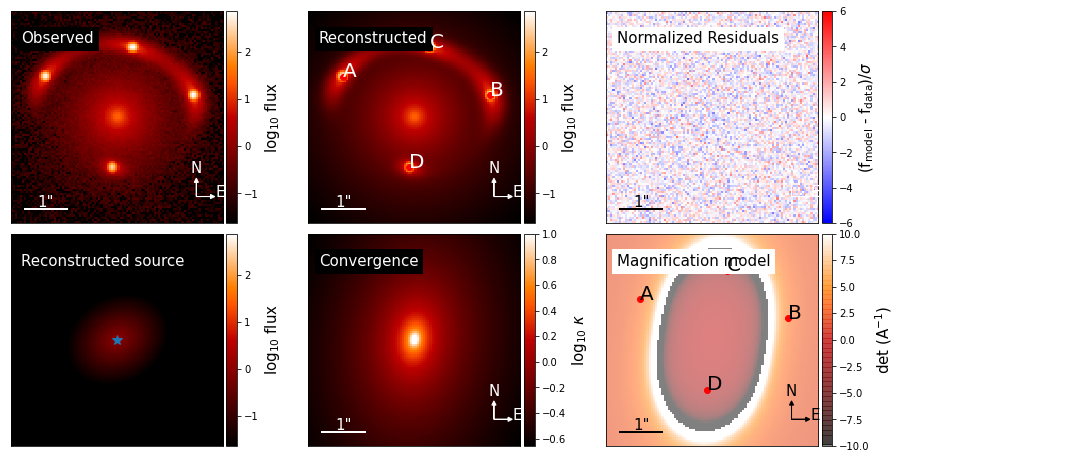

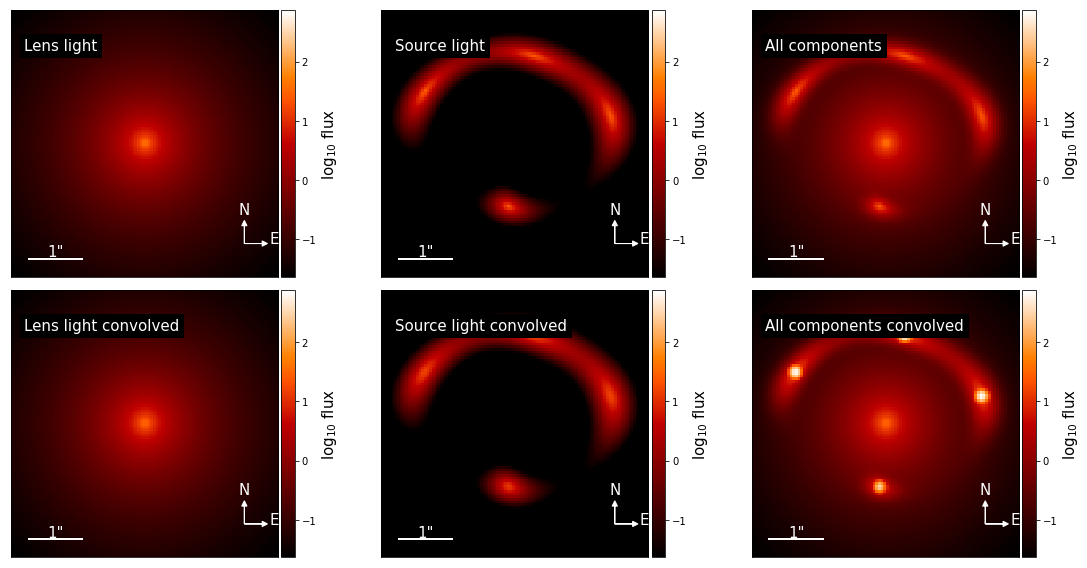

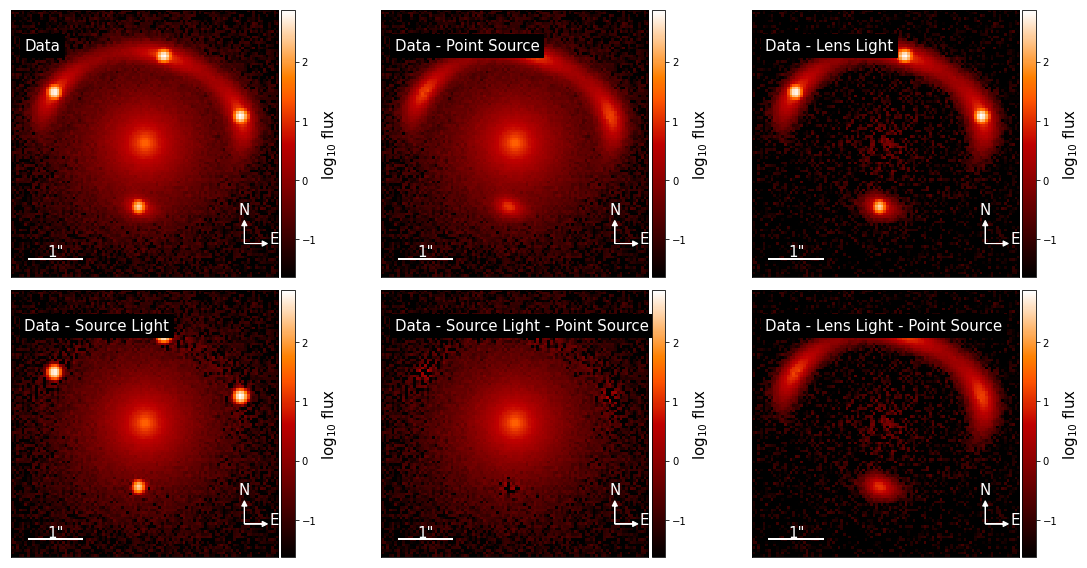

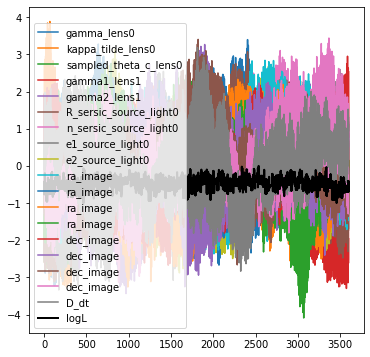

number of non-linear parameters in the MCMC process:  18
parameters in order:  ['gamma_lens0', 'kappa_tilde_lens0', 'sampled_theta_c_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  360000


In [5]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

# Figures of mock reconstruction
modelPlot = ModelPlot(multi_band_list, kwargs_model_uldm, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f, axes = modelPlot.plot_separate()
f, axes = modelPlot.plot_subtract_from_data_all()

# Plot the chain
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
chain_plot.plt.show()

if start_from_backup == True:
    chain_list_index = 0
else:
    chain_list_index = 1

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[chain_list_index]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

In [6]:
import corner
# import the parameter handling class
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model_uldm, fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_cosmo,
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

# This to make a range for the cornerplot, single numbers are to make a fraction
# of the whole range, cutting bounds (1 means don't cut anything)
range_ = [1, 1, 1, 1, 1]

# Correcting the \theta_E by considering scaling with kappa_E rather than kappa_0
theta_E_truth = 1.66 * (1 - 0.09) / (1 - 0.09*(1 + (1.6488*0.09)**2)**(0.5 - 3.78) )
kappa_E_real = 0.09*(1 + (1.6488*0.09)**2)**(0.5 - 3.78)
truths = [1.98, theta_E_truth, 0.09, kappa_E_real, 67.4]
# title_kwargs and label_kwarks can be used to change fontsizes
kwargs_corner = {'bins': 20, 'plot_datapoints': False, 'show_titles': True, 'title_kwargs': dict(fontsize = 18),
                 'label_kwargs': dict(fontsize=20), 'smooth': 0.5, 'levels': [0.68,0.95],
                 'fill_contours': True, 'alpha': 0.8  #, 'range': range_
                 }

# Set to False if you want to just change customization things
# of the corner plot
reprocess_corner = False
mcmc_new_list = []

labels_new_sampled_theta_c = [r"$\gamma$", r"$ \tilde{\theta}_{\rm E} $", r"$ \kappa_{\lambda}(\tilde{\theta}_{\rm E}) $", r"$ 1/\theta_{\rm c} $", r"$ H_0 $"]
if reprocess_corner == True:
    for i in range(len(samples_mcmc)):
        # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
        kwargs_result = param.args2kwargs(samples_mcmc[i])
        gamma = kwargs_result['kwargs_lens'][0]['gamma']
        theta_E = kwargs_result['kwargs_lens'][0]['theta_E']
        kappa_tilde, sampled_theta_c = kwargs_result['kwargs_lens'][0]['kappa_tilde'], kwargs_result['kwargs_lens'][0]['sampled_theta_c']

        theta_E_MSD = tilde_theta_finder(kappa_tilde, sampled_theta_c, theta_E)
        composite_profile = Uldm_PL()
        kappa_E = composite_profile._kappa_E(theta_E, theta_E_MSD, kappa_tilde, sampled_theta_c)
        theta_c = 1/sampled_theta_c

        ddt_mcmc = kwargs_result['kwargs_special']['D_dt']
        h0 = 70 * Ddt_reference / ddt_mcmc
        h0_MSD = h0*(1 - kappa_E)

        mcmc_new_list.append([gamma, theta_E, kappa_E, sampled_theta_c, h0_MSD, h0])

    file_name = 'mock_corner_'+name_flag+'.h5'
    h5file = h5py.File(file_name, 'w')
    h5file.create_dataset("dataset_mock", data=mcmc_new_list)
    h5file.close()
else:
    file_name = 'mock_corner_'+name_flag+'.h5'
    h5file = h5py.File(file_name, 'r')
    mcmc_new_list = h5file['dataset_mock'][:]
    h5file.close()

Quantile for inverse theta_c 0.11080401899553012


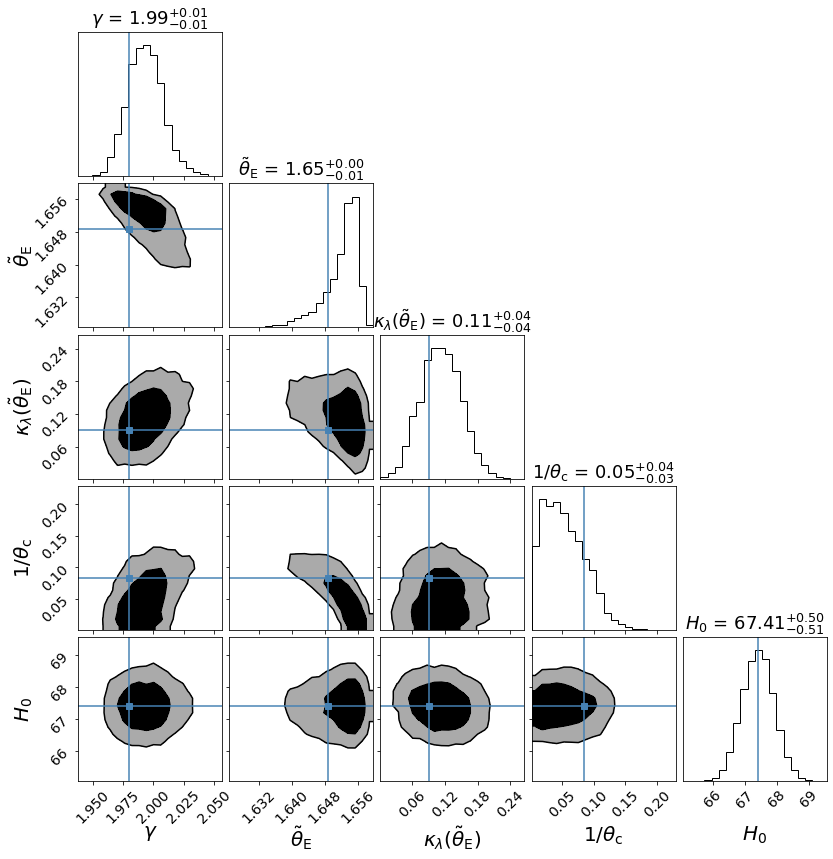

In [7]:
# Plot corner plot, run a longer chain to have better results
mcmc_new_list = np.array(mcmc_new_list)
plot = corner.corner(mcmc_new_list[:,:5], labels=labels_new_sampled_theta_c, range = range_, truths = truths,**kwargs_corner)
for ax in plot.get_axes(): # Workaround to change the number fontsize
    ax.tick_params(axis='both', labelsize=14)

print('Quantile for inverse theta_c', np.quantile(mcmc_new_list[:,3] , 0.95))

In [8]:
# delta_E check
from lenstronomy.LensModel.Profiles.uldm import Uldm
# Constants in SI
eV2Joule = 1.6021*10**(-19)
hbar = 6.62 * 10**(-34) / (2* np.pi)
pc2meter = 3.086 * 10**(16)
arcsec2rad = 4.84814 * 10**(-6)
clight = 3*10**8
G_const = 6.67 * 10**(-11)
m_sun = 1.989 * 10**(30)

def find_lambda(x, *arguments):

    lambda_factor = x
    theta_E, kappa_E, inverse_theta_c = arguments
    tilde_theta_E = theta_E * (1 - kappa_E)

    h0 = 67.4
    cosmo = FlatLambdaCDM(H0 = h0, Om0 = 0.3, Ob0 = 0)
    lens_cosmo = LensCosmo(z_lens = 0.5, z_source = 1.5, cosmo = cosmo)
    D_Lens = lens_cosmo.dd * 10**6 * pc2meter # in meter
    Sigma_c = lens_cosmo.sigma_crit * 10**(-12) * m_sun / pc2meter**2 # in kg/m^2

    A_factor = 2 * G_const / clight**2 * Sigma_c * D_Lens * tilde_theta_E * arcsec2rad
    z_fit = np.abs(A_factor / lambda_factor**2)
    a_fit = 0.23 * np.sqrt(1 + 7.5 * z_fit * np.tanh( 1.5 * z_fit**(0.24)) )
    b_fit = 1.69 + 2.23/(1 + 2.2 * z_fit)**(2.47)
    slope = 2*b_fit

    relation = lambda_factor**2 * clight**2 * gamma_func(slope - 0.5) / arcsec2rad
    relation = relation /(4 * np.sqrt(np.pi) * G_const * Sigma_c * a_fit**2 * D_Lens * gamma_func(slope))
    relation = relation * (1 + (theta_E*inverse_theta_c)**2)**(0.5 - slope)
    eq = kappa_E / inverse_theta_c - relation
    return eq

def err_at_theta_E(theta_E, inverse_theta_c, kappa_E):

    arguments = (theta_E, kappa_E, inverse_theta_c)
    lambda_factor = fsolve(find_lambda, 0.002, args=arguments)
    h0 = 67.4
    cosmo = FlatLambdaCDM(H0 = h0, Om0 = 0.3, Ob0 = 0)
    lens_cosmo = LensCosmo(z_lens = 0.5, z_source = 1.5, cosmo = cosmo)
    D_Lens = lens_cosmo.dd * 10**6 * pc2meter # in meter
    Sigma_c = lens_cosmo.sigma_crit * 10**(-12) * m_sun / pc2meter**2 # in kg/m^2

    tilde_theta_E = theta_E * (1 - kappa_E)
    A_factor = 2 * G_const / clight**2 * Sigma_c * D_Lens * tilde_theta_E * arcsec2rad
    z_fit = A_factor / lambda_factor**2
    a_fit = 0.23 * np.sqrt(1 + 7.5 * z_fit * np.tanh( 1.5 * z_fit**(0.24)) )
    b_fit = 1.69 + 2.23/(1 + 2.2 * z_fit)**(2.47)
    slope = 2*b_fit
    ratio = (theta_E* inverse_theta_c)**2
    numerator = (1+ratio)**(2*b_fit -0.5) - (2*b_fit - 0.5) * ratio -1
    denominator = (2*b_fit - 1.5) * ratio
    return numerator/denominator * kappa_E

def slope_func(theta_E, inverse_theta_c, kappa_E):

    arguments = (theta_E, kappa_E, inverse_theta_c)
    lambda_factor = fsolve(find_lambda, 0.002, args=arguments)
    h0 = 67.4
    cosmo = FlatLambdaCDM(H0 = h0, Om0 = 0.3, Ob0 = 0)
    lens_cosmo = LensCosmo(z_lens = 0.5, z_source = 1.5, cosmo = cosmo)
    D_Lens = lens_cosmo.dd * 10**6 * pc2meter # in meter
    Sigma_c = lens_cosmo.sigma_crit * 10**(-12) * m_sun / pc2meter**2 # in kg/m^2

    tilde_theta_E = theta_E * (1 - kappa_E)
    A_factor = 2 * G_const / clight**2 * Sigma_c * D_Lens * tilde_theta_E * arcsec2rad
    z_fit = A_factor / lambda_factor**2
    a_fit = 0.23 * np.sqrt(1 + 7.5 * z_fit * np.tanh( 1.5 * z_fit**(0.24)) )
    b_fit = 1.69 + 2.23/(1 + 2.2 * z_fit)**(2.47)
    slope = 2*b_fit
    return slope[0]

theta_E_PL = 1.6558524467847058
kappa_E = 0.09
inverse_theta_c_plot = np.linspace(0.01, 0.2, 30)
delta_plot = [err_at_theta_E(theta_E_PL, inverse_theta_c_single, kappa_E)
        for inverse_theta_c_single in inverse_theta_c_plot]

labels = [r"$ 1/\theta_{\rm c} $", r"$ \delta_{\rm E} $"]
#  mcmc_new_list = mcmc_new_list[:,(1,2,3)]
mcmc_new_list = mcmc_new_list[:,(1,2,3)]
delta_E_list = []
kappa_E_range = 0.002

# Set to True if you have already run this
take_from_file = False
if take_from_file == True:
    file_name = 'delta_E_mcmc.pkl'
    filedata = open(file_name, 'rb')
    delta_E_list = pickle.load(filedata)
    filedata.close()
else:
    file_name = 'delta_E_mcmc.pkl'
    filedata = open(file_name, 'wb')
    for i in range(len(mcmc_new_list)):
        if kappa_E - kappa_E_range < mcmc_new_list[i,1] < kappa_E + kappa_E_range:
            theta_E = mcmc_new_list[i,0]
            inverse_theta_c = mcmc_new_list[i,2]
            slope = slope_func(theta_E, inverse_theta_c, kappa_E)
            kappa_0 = kappa_E * ( 1 + (theta_E*inverse_theta_c)**2)**(slope - 0.5)
            alpha_theta_E = Uldm().alpha_radial(theta_E_PL, kappa_0, inverse_theta_c, slope) + (1 - kappa_E)*theta_E
            delta_E_list.append([inverse_theta_c, alpha_theta_E/ theta_E_PL -1 ])
    pickle.dump(delta_E_list, filedata)
    filedata.close()

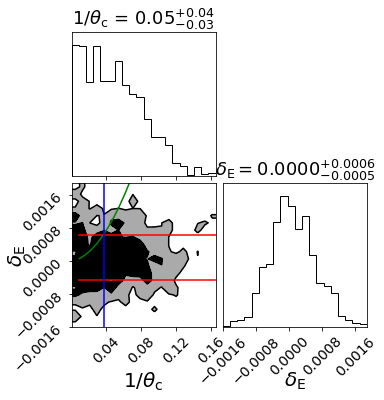

In [9]:
# Plot \delta_E check, run a longer chain for better result
delta_E_list = np.array(delta_E_list)
kwargs_corner = {'bins': 20, 'plot_datapoints': False, 'show_titles': True, 'title_kwargs': dict(fontsize = 18),
                'smooth': 0.5, 'label_kwargs': dict(fontsize=20), 'labels': labels, 'levels': [0.68, 0.95], # [0.393,0.865],
                 'fill_contours': True, 'alpha': 0.8  #, 'range': range_
                 }
plot = corner.corner(delta_E_list, **kwargs_corner)
for ax in plot.get_axes(): # Workaround to change the number fontsize
    ax.tick_params(axis='both', labelsize=14)

delta_16, delta_50, delta_84 = np.quantile(np.array(delta_E_list)[:,1] , [0.16, 0.5, 0.84])

# Extract the axes
ndim = 2
axes = np.array(plot.axes).reshape((ndim, ndim))
# Loop over the histograms
ax = axes[1, 0]
ax.plot(inverse_theta_c_plot, delta_plot, "g")
ax.plot(inverse_theta_c_plot, delta_84*np.ones(30), "r")
ax.plot(inverse_theta_c_plot, delta_16*np.ones(30), "r")
ax.axvline(0.038, color = 'b')
ax2 = axes[1, 1]
ax2.set_title(r'$\delta_{\rm E} = %1.4f^{+%1.4f}_{-%1.4f} $' % (delta_50, delta_84 - delta_50, delta_50 - delta_16), fontsize = 18 )

plt.show()